# select waveforms

#### 1) Select events using a run's DST file -- > 2) Look at those events' waveforms

Here, I use this notebook to look at the waveforms of sodium events with the photoelectric peak

In [1]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-04-24 17:16:51


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import time
import tables as tb
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [4]:
from invisible_cities.database import load_db

In [5]:
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.params import S12Params, ThresholdParams
from   invisible_cities.core.system_of_units_c import units
from invisible_cities.core.core_functions import in_range


In [6]:
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus

In [7]:
from invisible_cities.reco.pmaps_functions import plot_s12

In [8]:
sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')
from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 

### Run Parameters

In [9]:
run_number =  3723

# consecutive!
subruns     = ['025','026','027','028','029']

In [10]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

### 1) HAVE ACCESS TO WVFMS FROM CONSECTIVE SUBRUNS

In [11]:
## consecutive meaning subrun 025, 026, 027... for ex

RWF_path = os.path.join(os.environ['IC_DATA'], 'LSC/wvfms/{}/'.format(run_number))
RWF_files = [RWF_path + 'dst_waves.gdcsnext.{}_{}.root.h5'.format(subrun, run_number) for subrun in subruns]
print(RWF_files)

['/Users/alej/Desktop/IC_DATA/LSC/wvfms/3723/dst_waves.gdcsnext.025_3723.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3723/dst_waves.gdcsnext.026_3723.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3723/dst_waves.gdcsnext.027_3723.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3723/dst_waves.gdcsnext.028_3723.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3723/dst_waves.gdcsnext.029_3723.root.h5']


### 2) FIND STARTING AND FINAL EVENT IN THESE SUBRUNS

In [12]:
startfile = tb.open_file(RWF_files[0],'r')
sev = startfile.root.Run.events[0][0]
startfile.close()

endfile = tb.open_file(RWF_files[-1],'r')
fev = endfile.root.Run.events[-1][0]
endfile.close()
print('These subruns include events in this (inclusive) range: ')
print(sev, fev)

These subruns include events in this (inclusive) range: 
4101 4920


In [13]:
ifile = os.path.join(os.environ['IC_DATA'],
                        'LSC/kdst/{}/dst_{}.root.h5'.format(run_number,run_number))
print("ifile:", ifile)
full = load_dst(ifile)


ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/3723/dst_3723.root.h5


## 3) Select events in dst

In [14]:
srs = full[in_range(full.event, sev, fev)]
srspe = srs[in_range(srs.S1e, 100*units.pes, 150*units.pes)]

52 events of interest in these subruns


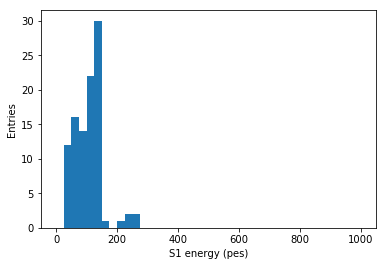

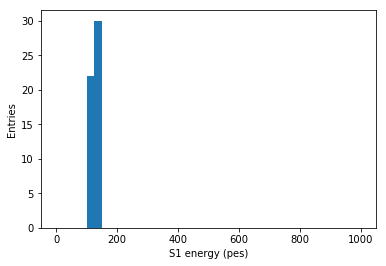

In [15]:
hist(srs.S1e, 40, (0,1000))
labels("S1 energy (pes)", "Entries")

hist(srspe.S1e, 40, (0,1000))
labels("S1 energy (pes)", "Entries")
print(len(srspe), 'events of interest in these subruns')

#### 4) open rwf_file from one subrun

In [16]:
sbr = 1
h5rwf = tb.open_file(RWF_files[sbr],'r')

In [17]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)

In [18]:
NEVT, NPMT, PMTWL = pmtrwf.shape
NEVT, NSIPM, SIPMWL = sipmrwf.shape
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL,NSIPM, SIPMWL))


        Number of events in file = 164
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


### 5) Select desired waveforms in this file

In [19]:
#sanity check
assert(NEVT == h5rwf.root.Run.events[-1][0] - h5rwf.root.Run.events[0][0] + 1)

ssev = h5rwf.root.Run.events[0][0]
sfev = h5rwf.root.Run.events[-1][0]

srpe = srspe[in_range(srspe.event, ssev, sfev)]
srevents = np.array(list(set(srpe.event.values)))
srinds = srevents - ssev

print('INDICES OF INTEREST IN THIS SUBRUN')
print(srinds)


# select wvfms
spmtrwf = np.array(pmtrwf) [srinds]
spmtblr = np.array(pmtblr) [srinds]
ssipmrwf= np.array(sipmrwf)[srinds]
    

INDICES OF INTEREST IN THIS SUBRUN
[29 31 32  1  2  8 13 14 16 17]


In [20]:
print(pmtrwf.shape)

(164, 12, 52000)


In [21]:
s1par  = S12Params(tmin=175*units.mus, tmax=225*units.mus, lmin=5, lmax=20, stride=4, rebin=False)
s2par = S12Params(tmin=225*units.mus, tmax=1300*units.mus, stride=80, lmin=80, lmax=20000, rebin=True)
thr    = ThresholdParams(thr_s1=3 * units.pes,  thr_s2=1*units.pes,
                        thr_MAU = 3 * units.adc, thr_sipm = 3.5 * units.pes,
                        thr_SIPM = 30 * units.adc)
epm = EventPmaps(run_number, s1par, s2par, thr, verbose=True)

In [22]:
event = 8

epm.calibrated_pmt_and_csum(event, spmtrwf)
epm.find_s1() # sanity check

number of peaks = 1
S12 number = 0, samples = 9 sum in pes =123.44921264049424
time vector (mus) = [ 200.05   200.075  200.1    200.125  200.15   200.175  200.2    200.225
  200.25 ]
energy vector (pes) = [  4.34633005  11.5358186   19.47871604  23.98783087  23.26610382
  18.8705062   12.32893072   6.41745535   3.217521  ]


1

### CSUM

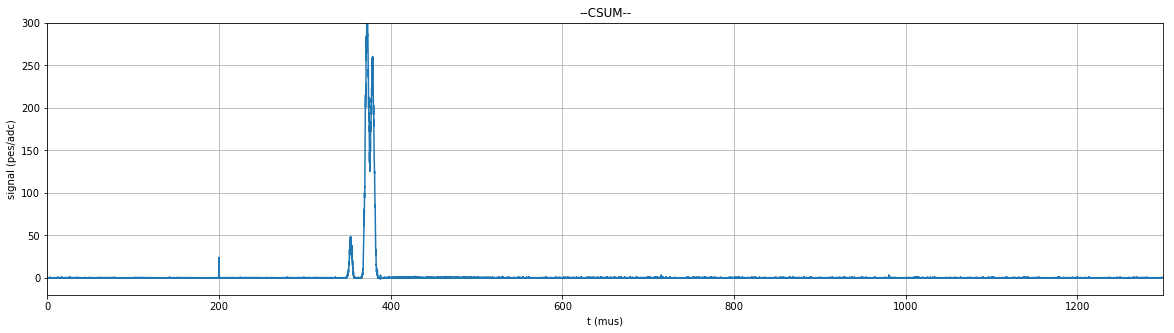

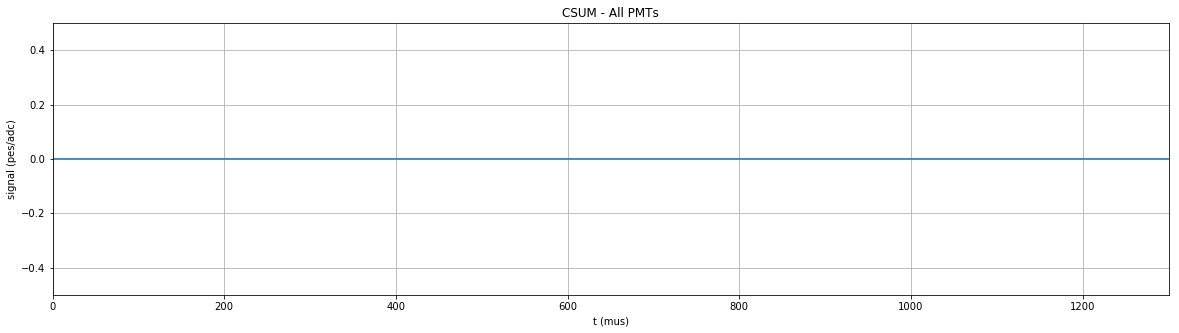

In [23]:
plot_signal_vs_time_mus(epm.csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-20, 
                            signal_max=300, figsize=(20,5))
plt.title('--CSUM--')
plt.show()

plot_signal_vs_time_mus(epm.csum - epm.CAL_PMT.sum(axis=0), 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-.5, 
                            signal_max=.5, figsize=(20,5))
plt.title('CSUM - All PMTs')
plt.show()

#### CSUM and each calibrated PMT

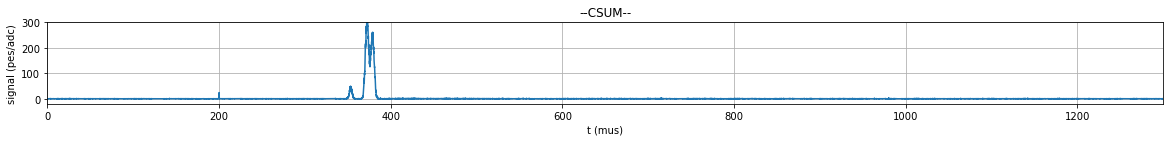

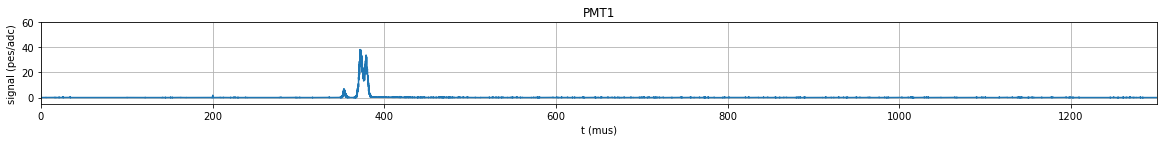

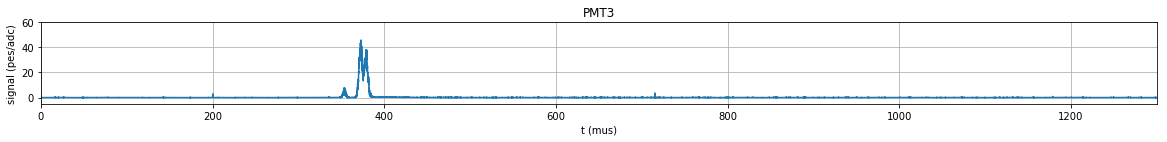

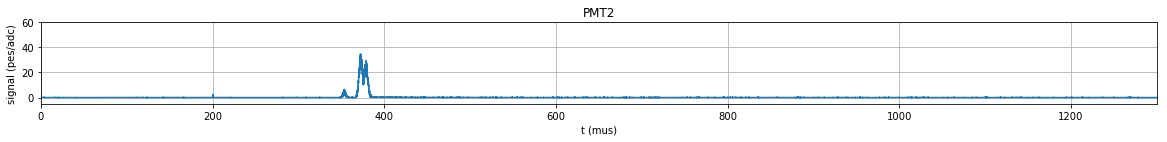

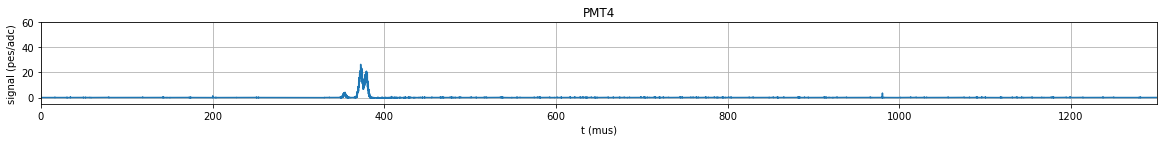

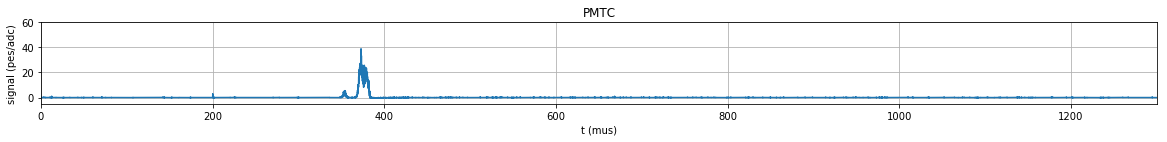

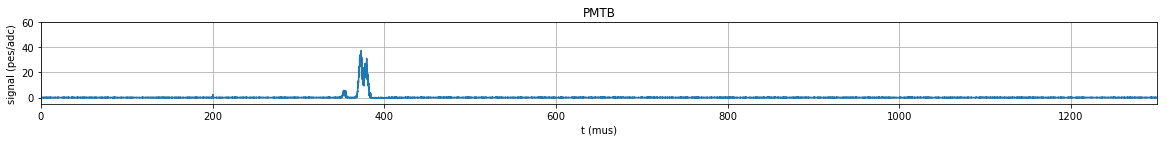

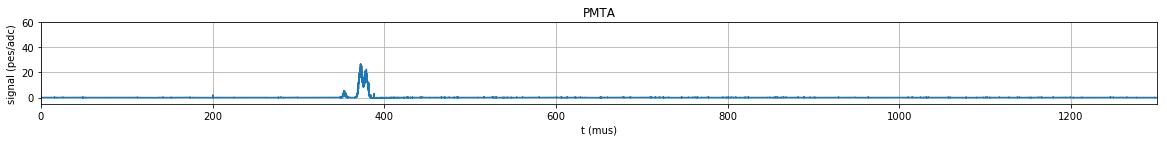

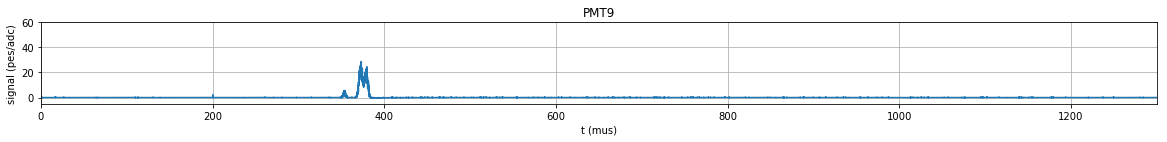

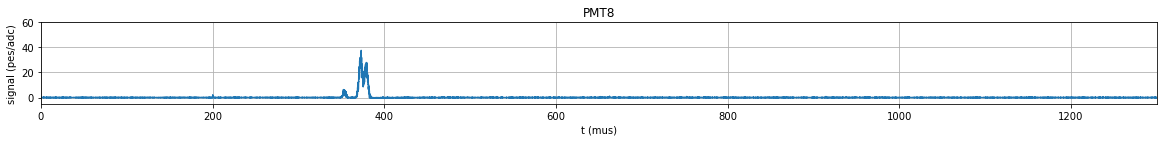

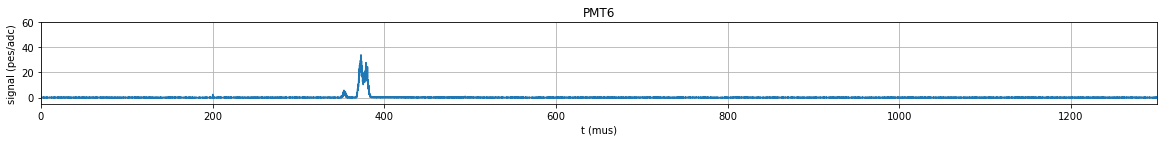

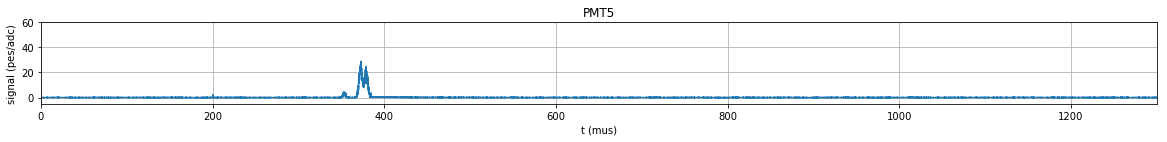

In [24]:
plot_signal_vs_time_mus(epm.csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-20, 
                            signal_max=300, figsize=(20,1.5))
plt.title('--CSUM--')
plt.show()

for i in range(11):
    plot_signal_vs_time_mus(epm.CAL_PMT[i],
                                 t_min      =    0,
                                 t_max      = 1300,
                                 signal_min =    -5,
                                 signal_max =  60, figsize=(20,1.5))
    plt.title(DataPMT.PmtID.values[i])
    plt.show()


#### CSUM, without each pmt

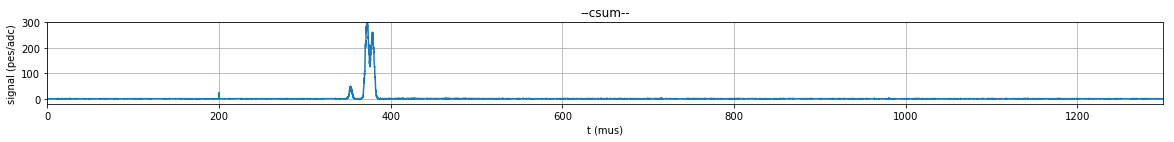

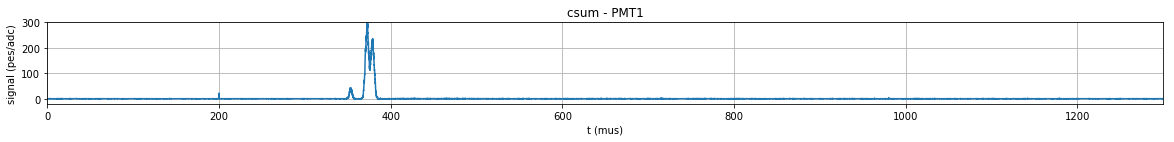

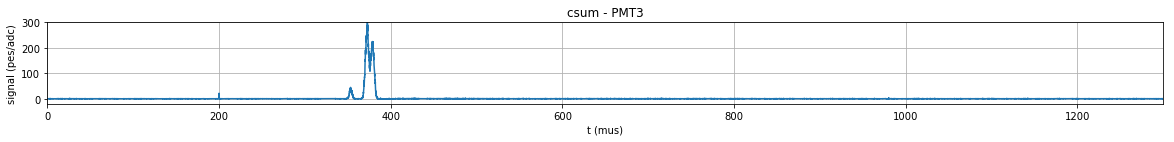

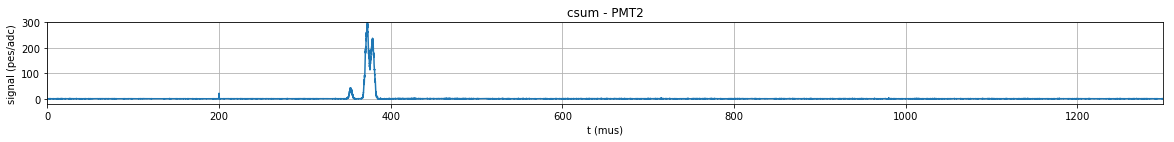

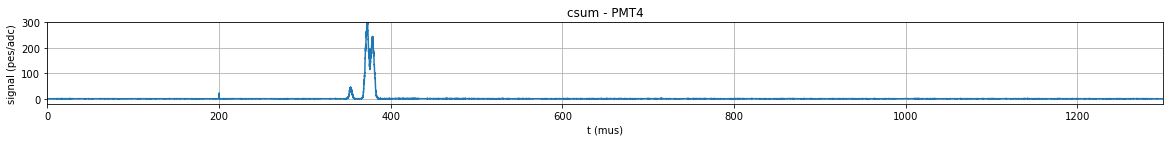

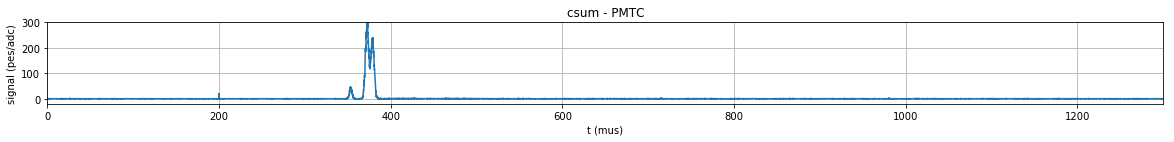

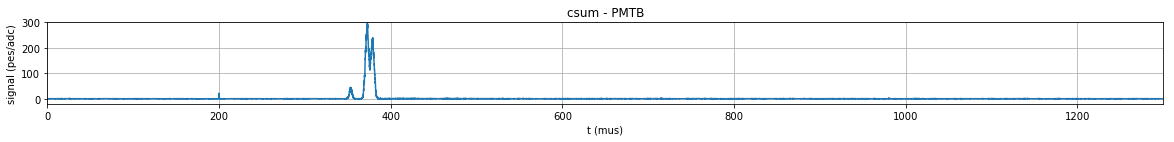

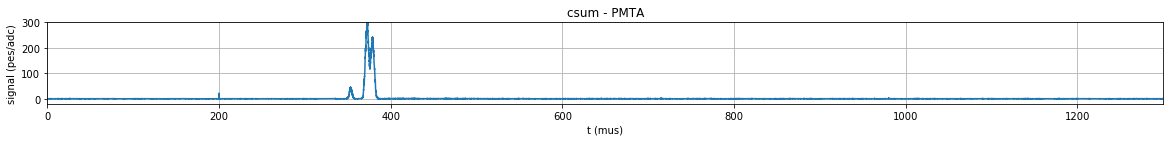

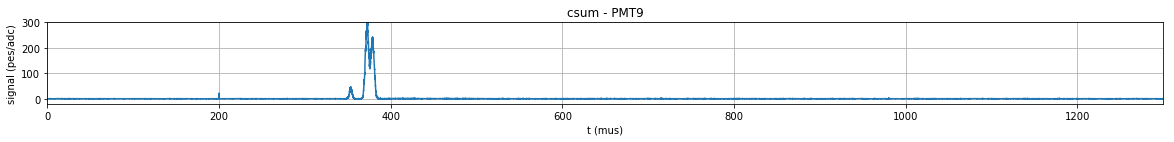

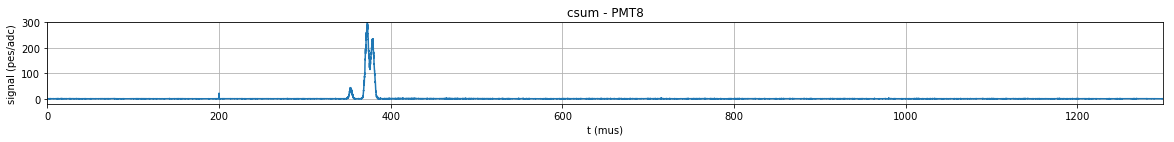

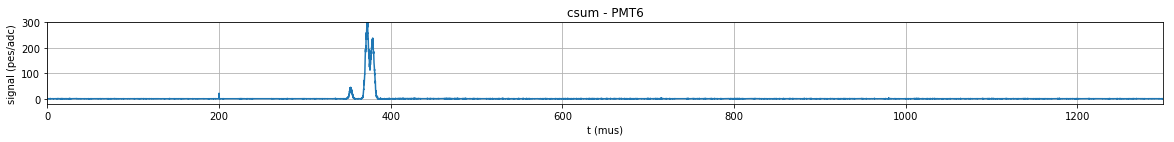

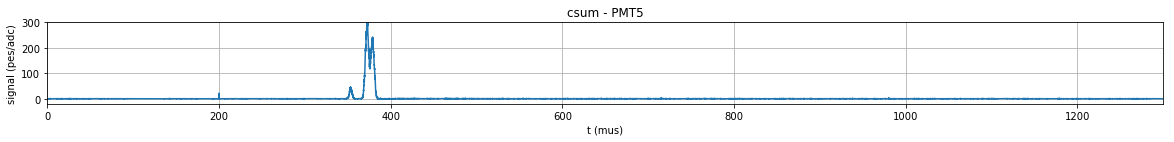

In [25]:
plot_signal_vs_time_mus(epm.csum,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -20,
                             signal_max =  300, figsize=(20,1.5))
plt.title('--csum--')
plt.show()

for i in range(11):
    plot_signal_vs_time_mus(epm.csum - epm.CAL_PMT[i],
                                 t_min      =    0,
                                 t_max      = 1300,
                                 signal_min =    -20,
                                 signal_max =  300, figsize=(20,1.5))
    plt.title('csum - ' + DataPMT.PmtID.values[i])
    plt.show()

#### Look at CWF baseline

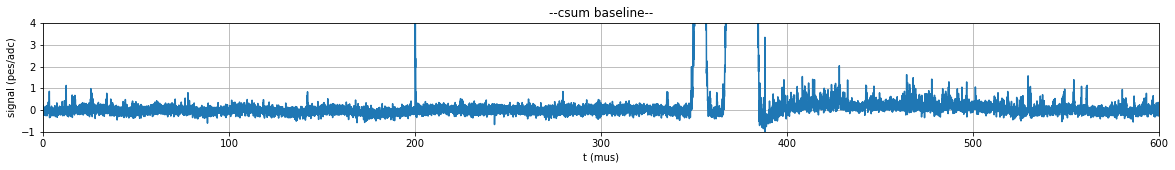

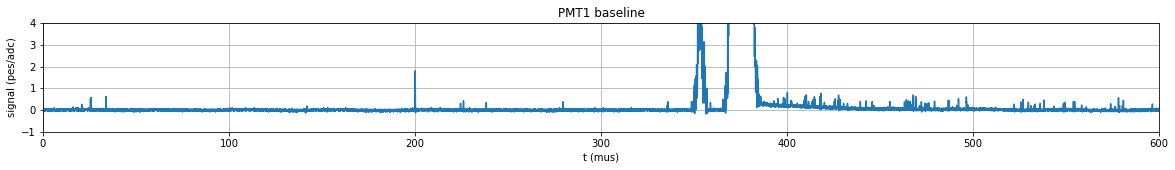

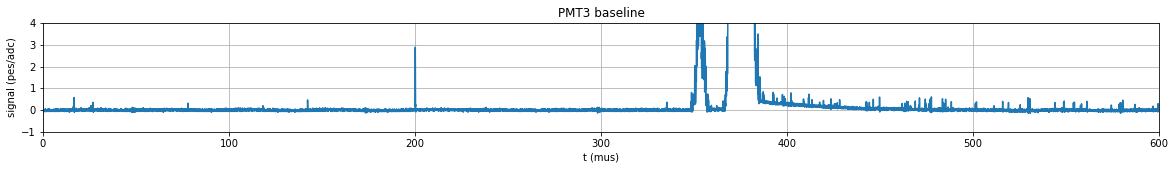

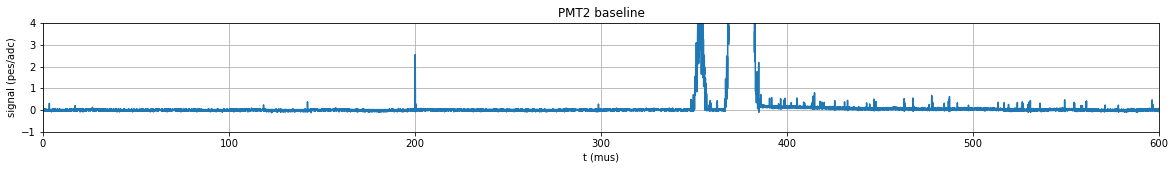

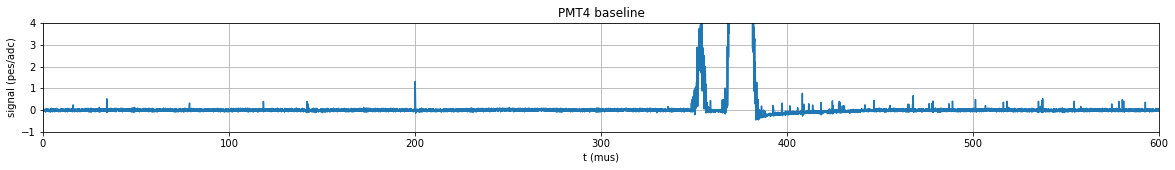

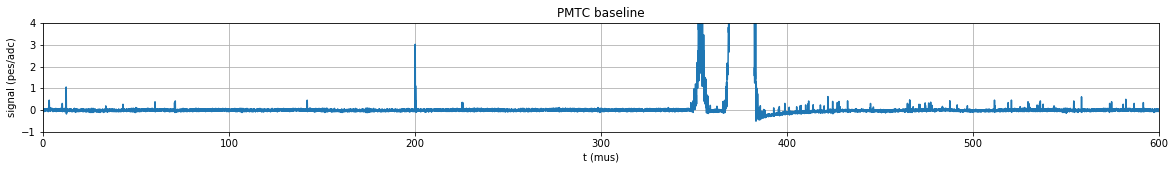

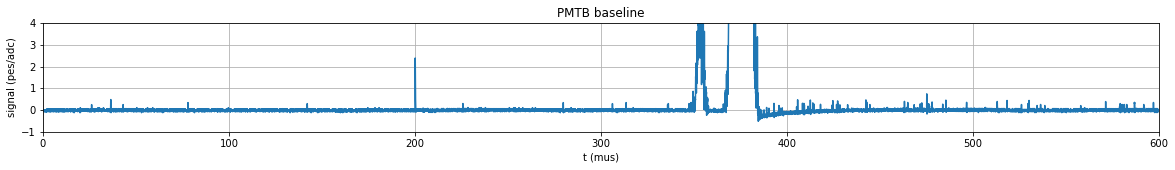

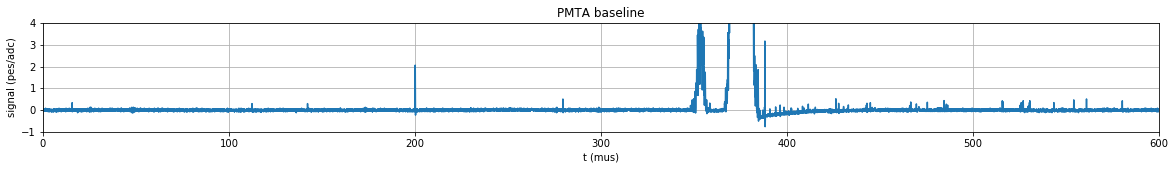

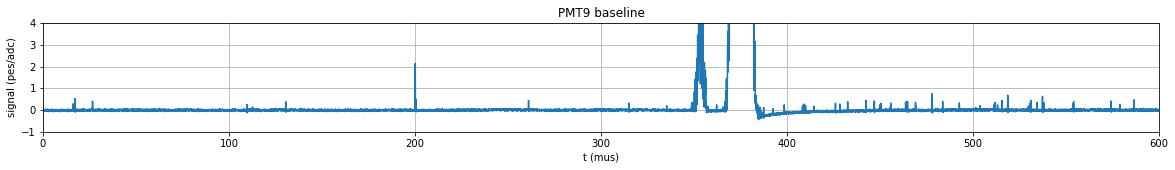

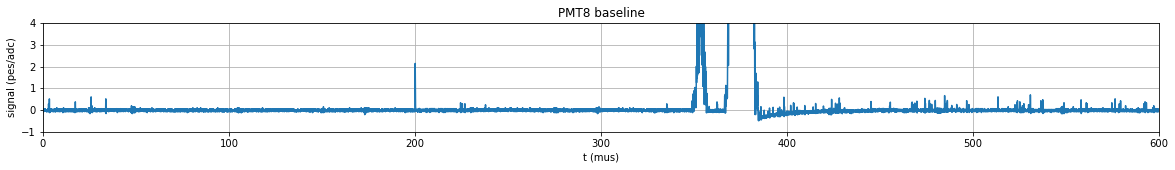

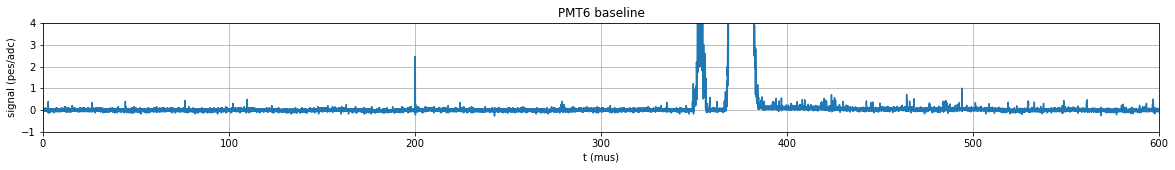

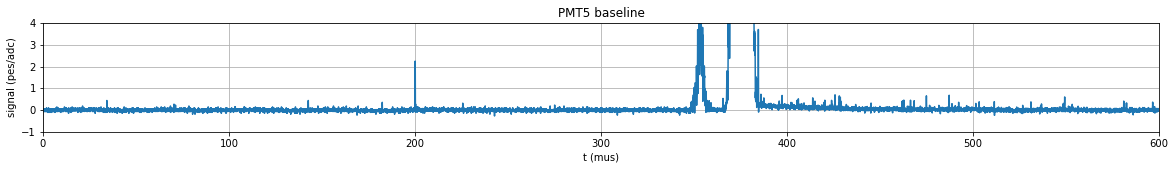

In [26]:
plot_signal_vs_time_mus(epm.csum,
                             t_min      =    0,
                             t_max      = 600,
                             signal_min =    -1,
                             signal_max =  4, figsize=(20,2))
plt.title('--csum baseline--')
plt.show()

for i in range(11):
    plot_signal_vs_time_mus(epm.CAL_PMT[i],
                                 t_min      =    0,
                                 t_max      = 600,
                                 signal_min =    -1,
                                 signal_max =  4, figsize=(20,2))
    plt.title(DataPMT.PmtID.values[i] + ' baseline')
    plt.show()

#### CSUM baseline,  without each pmt

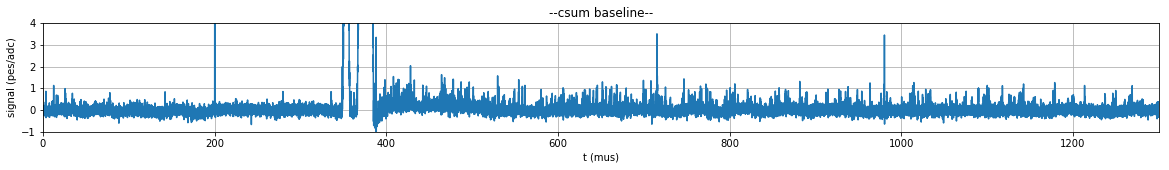

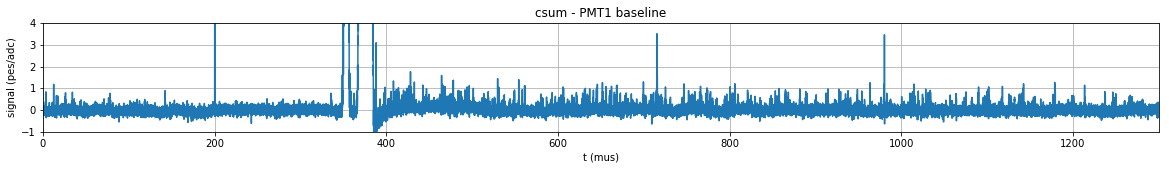

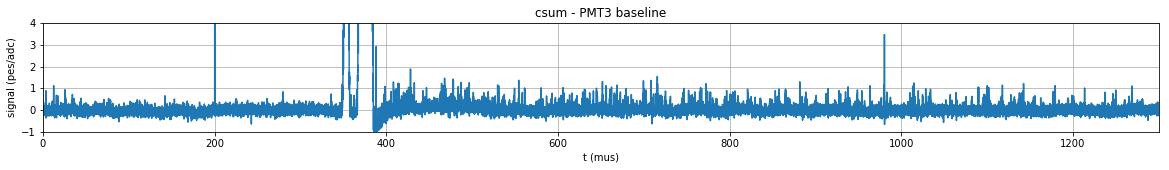

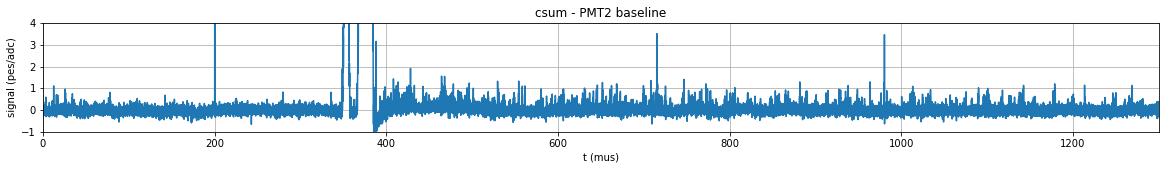

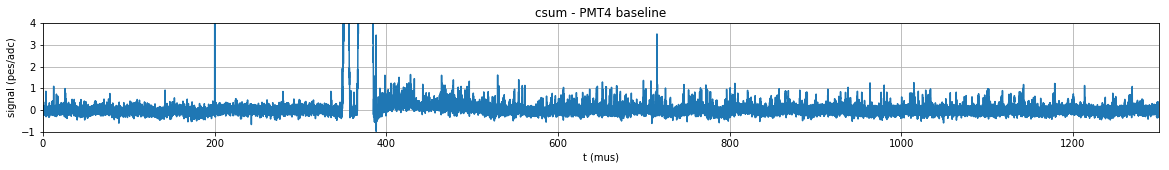

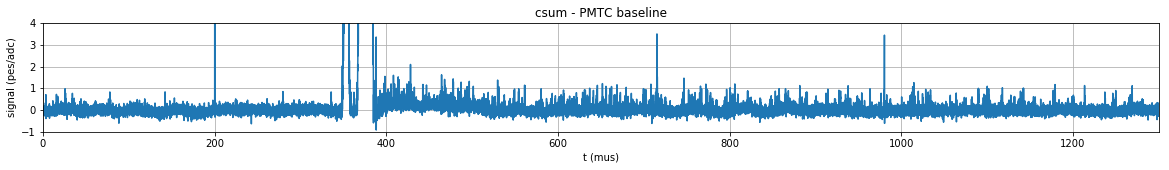

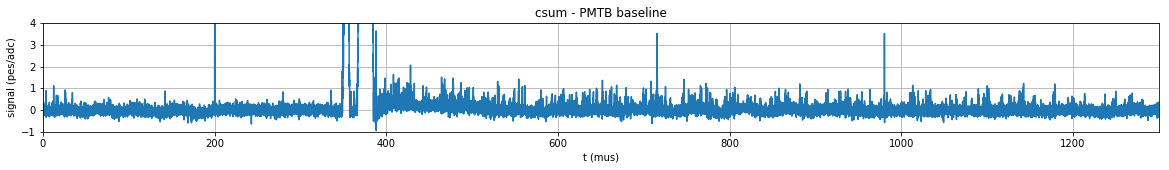

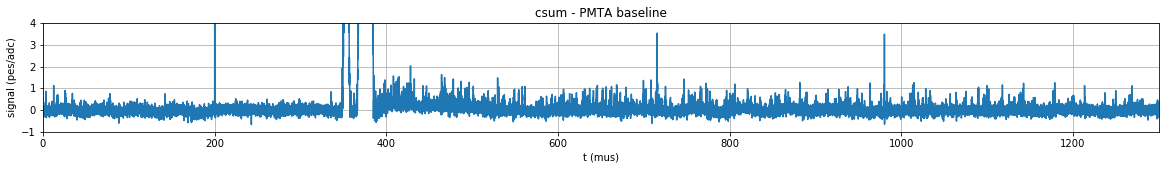

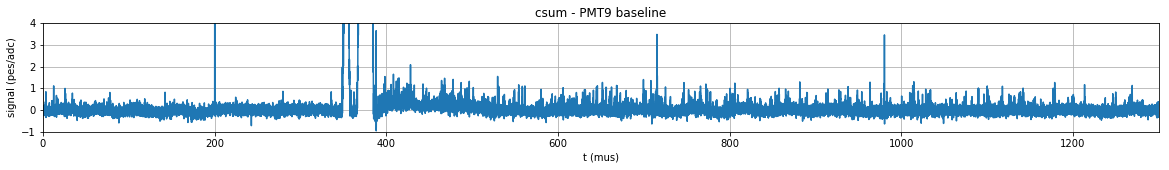

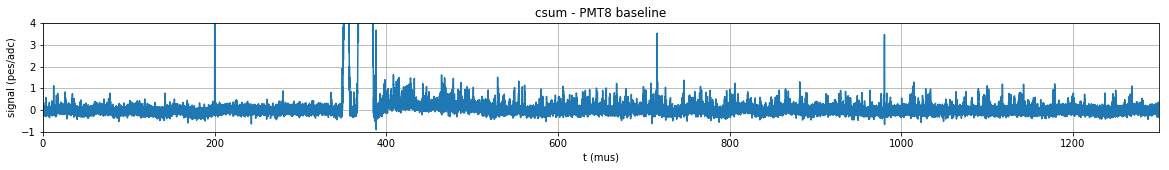

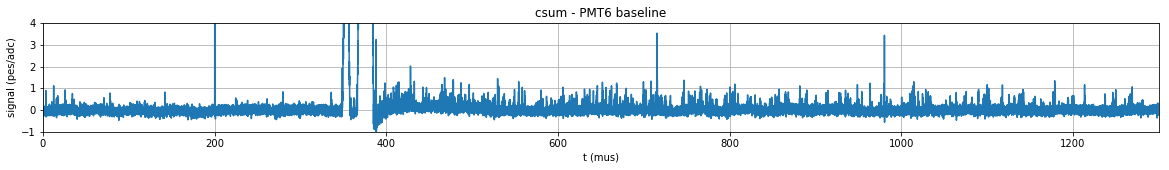

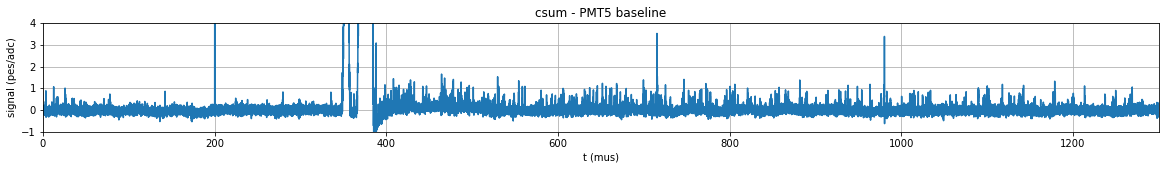

In [27]:
plot_signal_vs_time_mus(epm.csum,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -1,
                             signal_max =  4, figsize=(20,2))
plt.title('--csum baseline--')
plt.show()

for i in range(11):
    plot_signal_vs_time_mus(epm.csum - epm.CAL_PMT[i],
                                 t_min      =    0,
                                 t_max      = 1300,
                                 signal_min =    -1,
                                 signal_max =  4, figsize=(20,2))
    plt.title('csum - ' + DataPMT.PmtID.values[i] + ' baseline')
    plt.show()

#### Individual PMT S1s

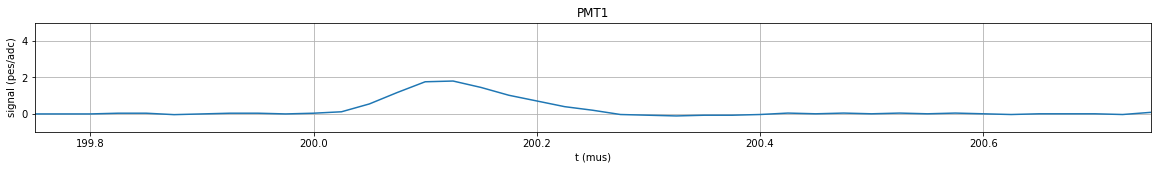

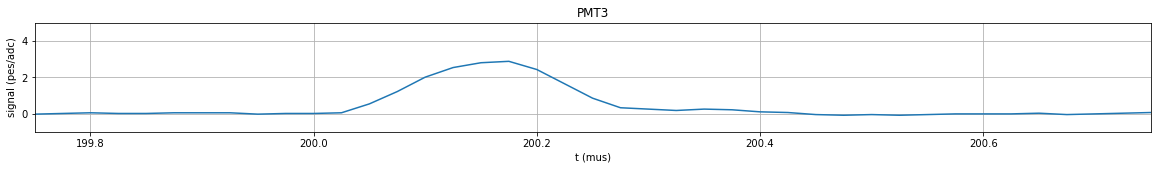

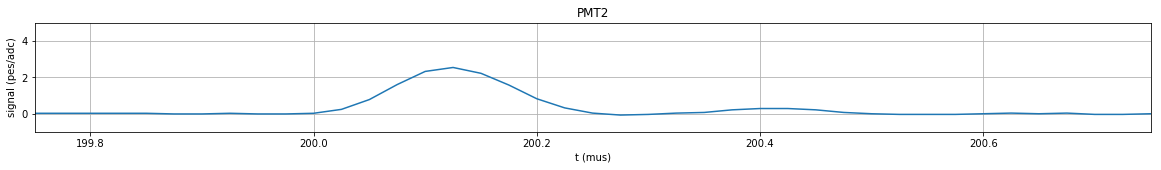

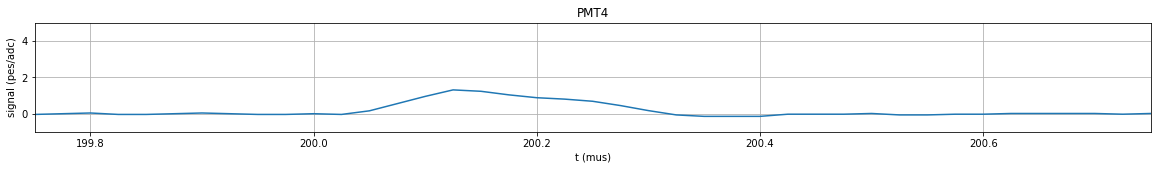

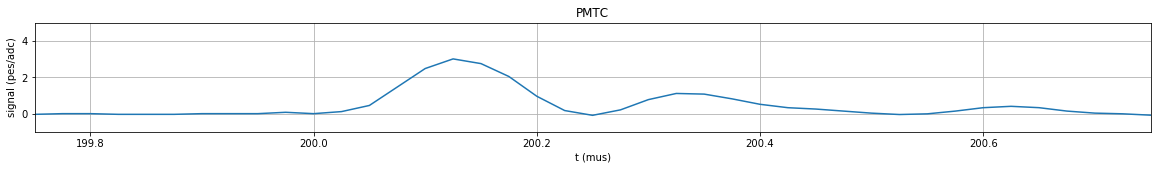

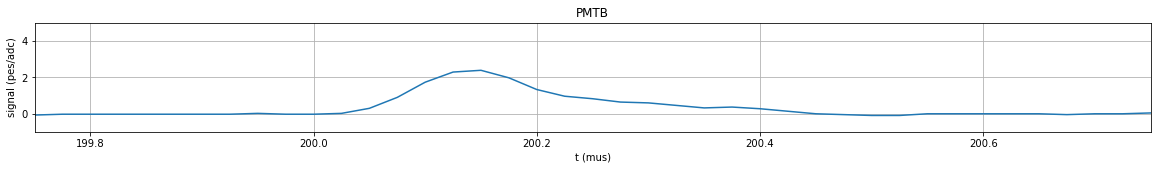

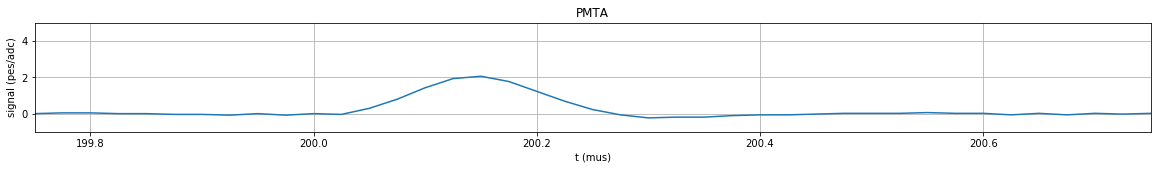

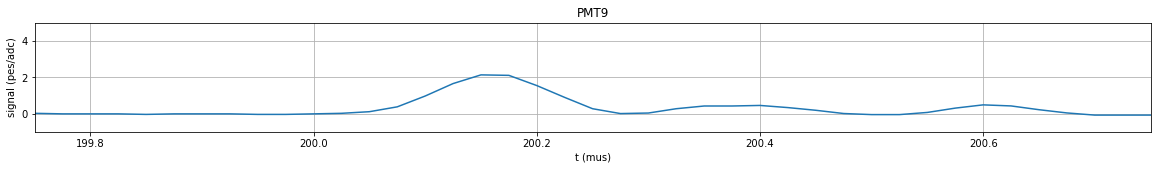

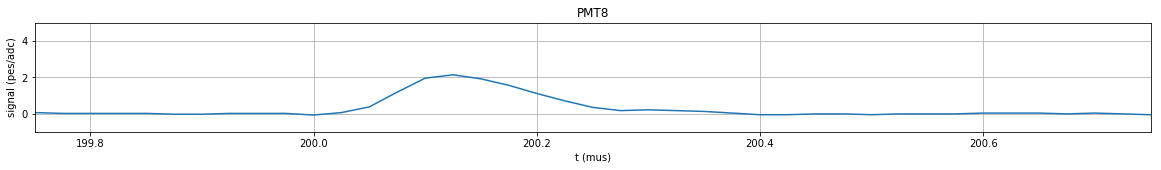

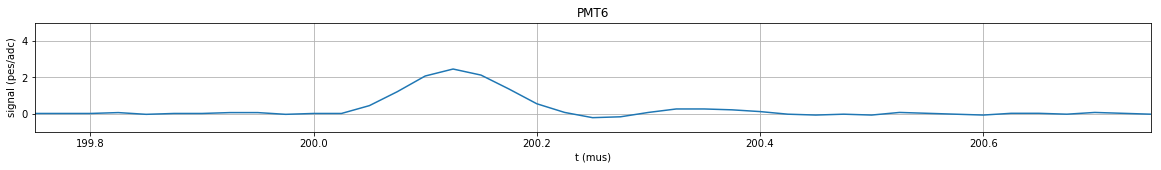

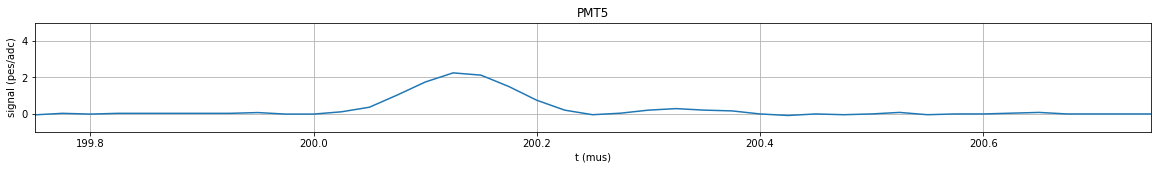

In [28]:
for i in range(11):
    plot_signal_vs_time_mus(epm.CAL_PMT[i],
                                 t_min      =    199.75,
                                 t_max      =    200.75,
                                 signal_min =    -1,
                                 signal_max =  5, figsize=(20,2))
    plt.title(DataPMT.PmtID.values[i])

In [29]:
epm.find_s2()

number of peaks = 2
S12 number = 0, samples = 9 sum in pes =6363.132136970401
time vector (mus) = [ 349.6375  350.7125  351.7125  352.7125  353.7125  354.7125  355.7125
  356.7125  357.2375]
energy vector (pes) = [  117.71284281   286.49401009   864.90342051  1590.32927378  1651.92248622
  1109.46443273   592.59091303   147.01749136     2.69726644]
S12 number = 1, samples = 19 sum in pes =107790.13861194142
time vector (mus) = [ 366.84875  367.8875   368.8875   369.8875   370.8875   371.8875   372.8875
  373.8875   374.8875   375.8875   376.8875   377.8875   378.8875   379.8875
  380.8875   381.8875   382.8875   383.8875   384.695  ]
energy vector (pes) = [   137.66638772    680.01304887   2421.13452416   5209.7736691
   8912.9561979   11373.59528117  12211.06993655   9680.03653111
   6914.37015101   5833.22182246   7300.83156859   8920.34467683
   9961.66547246   8304.0846629    5522.0867404    3088.06986427
    946.56522747    294.35347956     78.29936941]


2

0


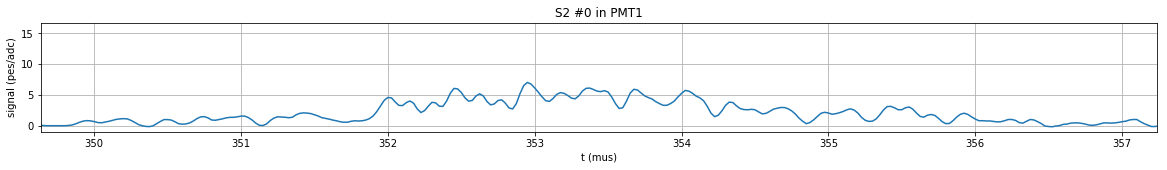

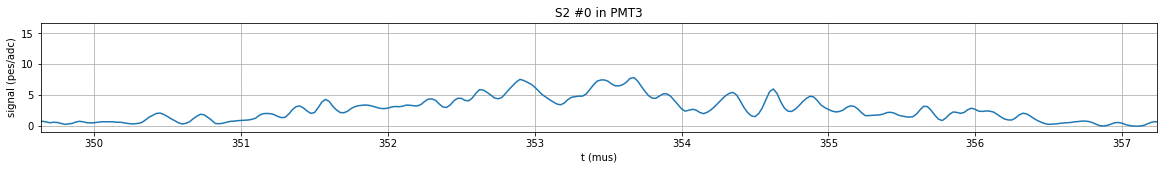

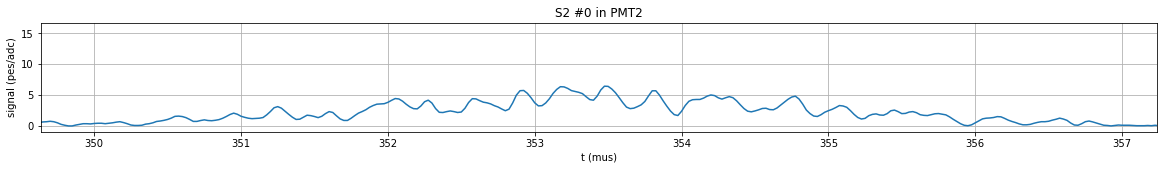

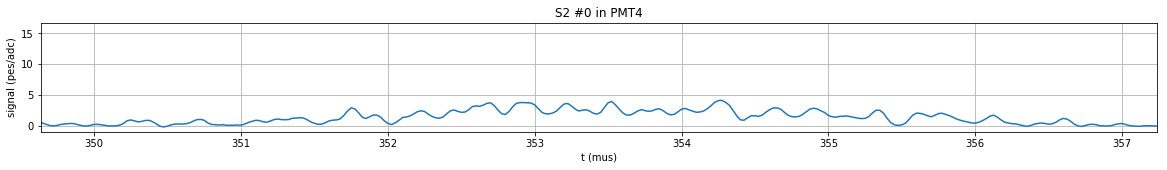

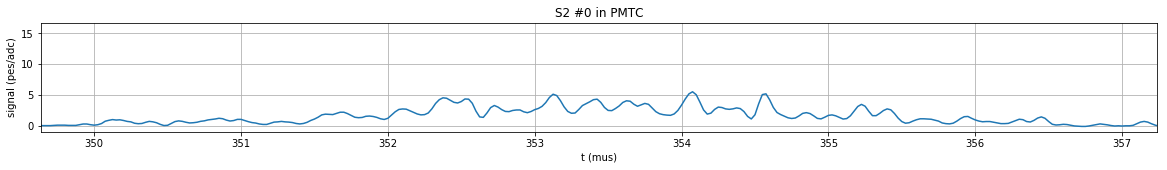

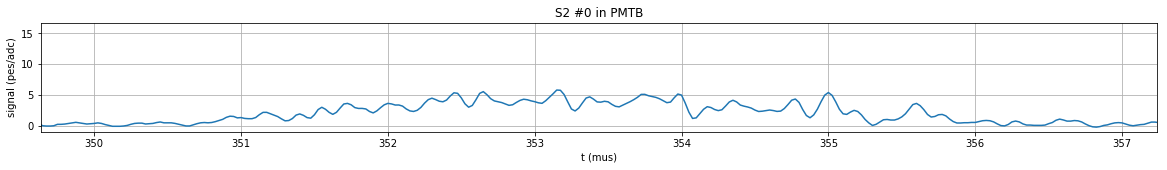

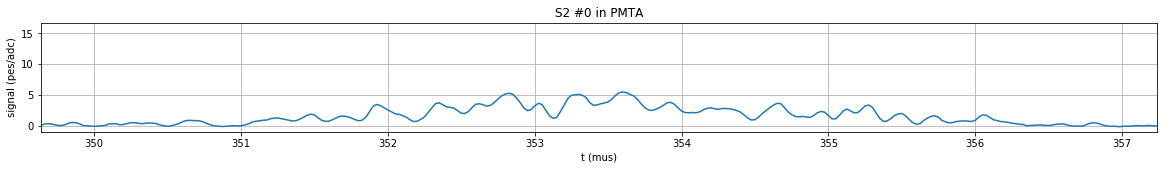

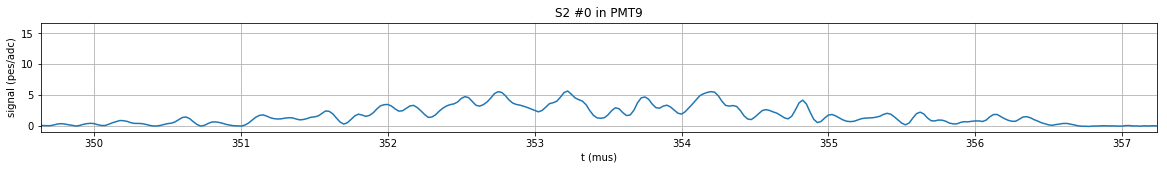

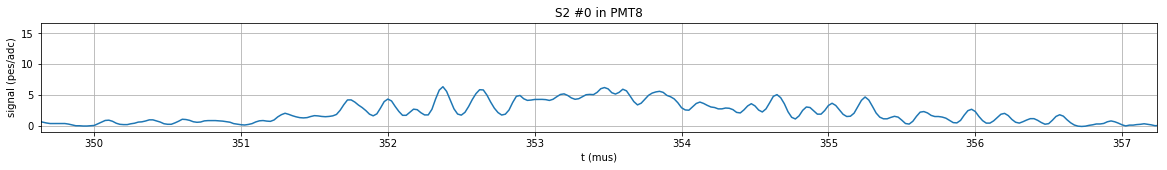

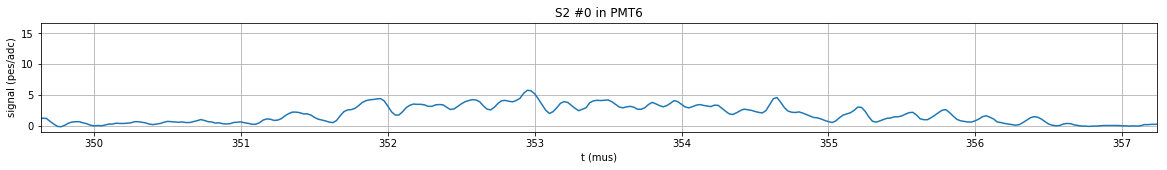

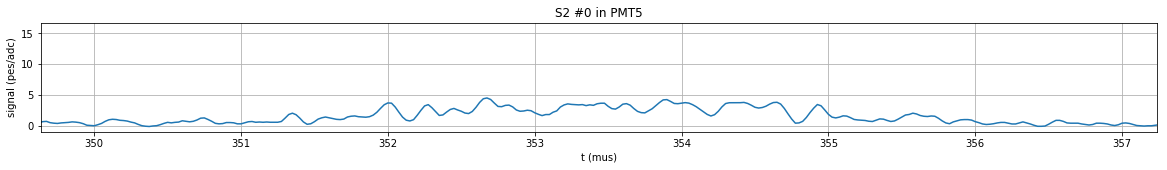

1


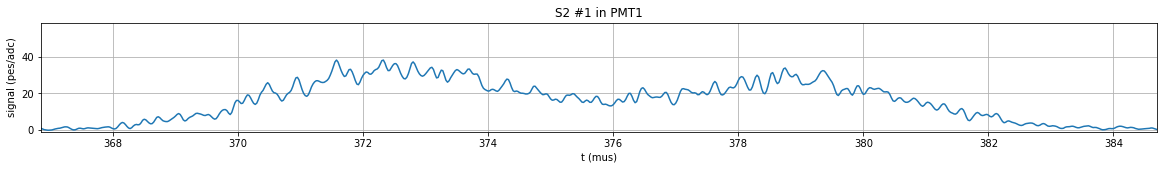

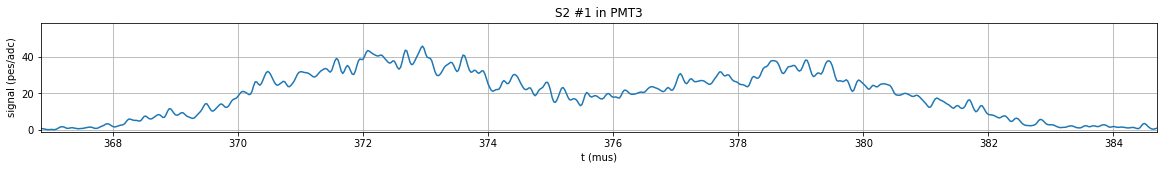

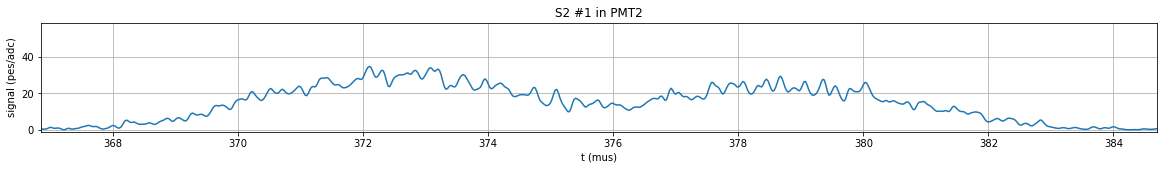

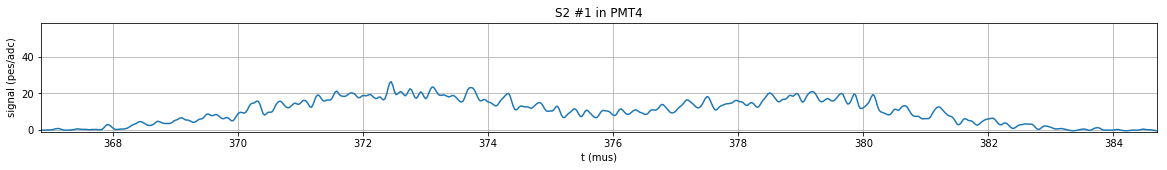

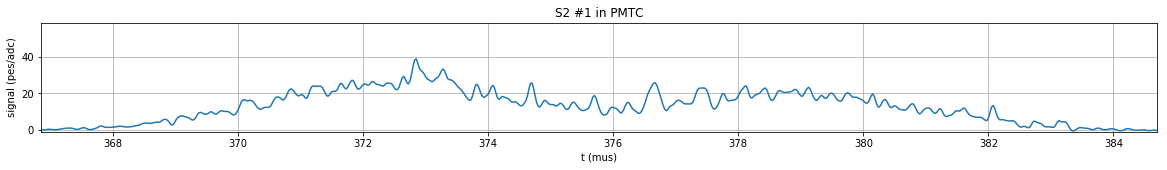

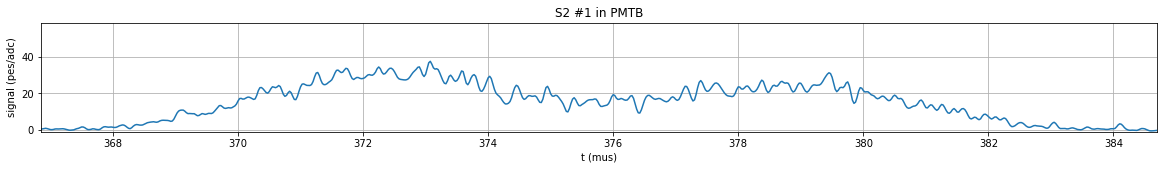

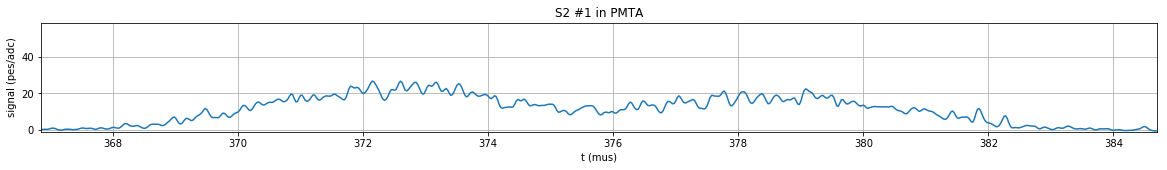

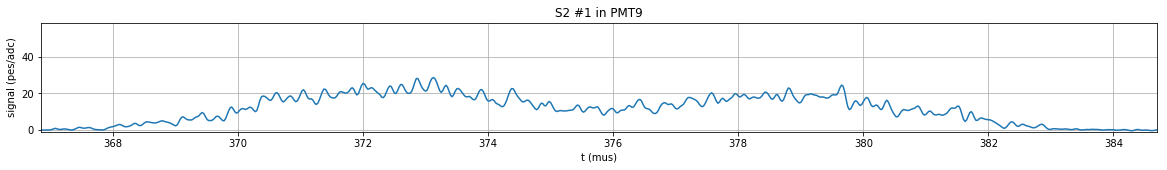

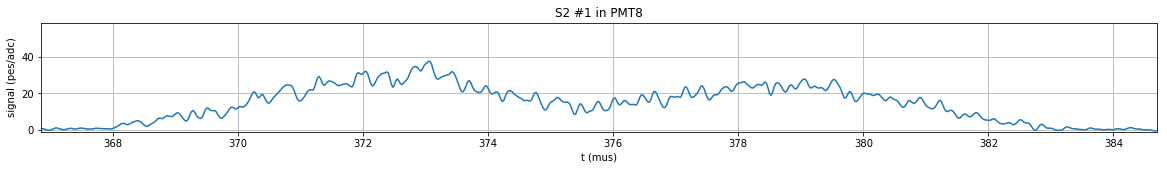

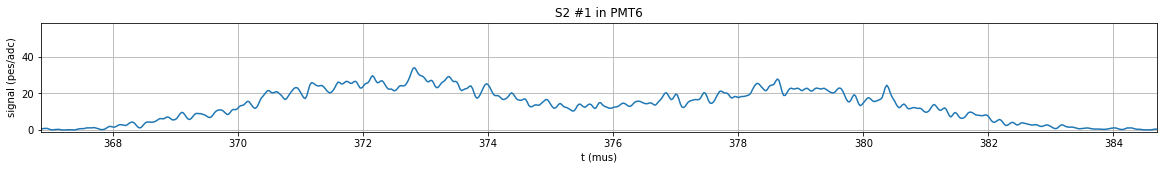

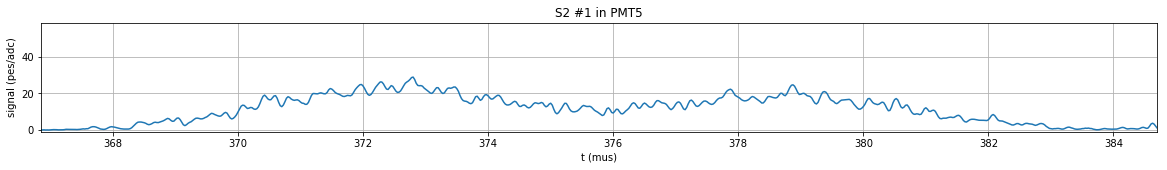

In [30]:
for s2 in epm.S2:
    print(s2)
    for i in range(11):
        plot_signal_vs_time_mus(epm.CAL_PMT[i],
                                     t_min      =    epm.S2[s2][0][0] / 1e3,
                                     t_max      =    epm.S2[s2][0][-1]/ 1e3,
                                     signal_min =    -1,
                                     signal_max =  epm.S2[s2][1].max()/float(len(epm.S2[s2][0]))/11., 
                                     figsize=(20,2))
        plt.title('S2 #' + str(s2) + ' in ' + DataPMT.PmtID.values[i])
        plt.show()
    print('===========================================================')
    print('===========================================================')